### Flower Recognition

### Import all required packages

In [1]:
# Importing all packages I will use throughout this notebook
import numpy as np
import pandas as pd 
import os
import PIL
import matplotlib.pyplot as plt
from IPython import display
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.regularizers import l2
from tensorflow.python.framework import ops
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 15)
path = '../input/extended-flowers-recognition/flowers/'

## Exploring the image data

In [2]:
path = '../input/extended-flowers-recognition/flowers/'
flowers = [file for file in os.listdir(path)]
print(flowers) ## See what classes of flowers we have

['orchid', 'aster', 'daffodil', 'dahlia', 'dandelion', 'daisy', 'sunflower', 'tulip', 'rose', 'iris']


In [3]:
## Define function to plot 20 random images from list_of_images
def show_random_images(path, labels):
    for i in range(20):
        label_idx = random.randint(0, len(labels)-1) # Select folder at random to choose from
        im_path = path + labels[label_idx] + '/'
        image_idx = random.randint(0, len([name for name in os.listdir(im_path)])-1) # Select image at random from folder
        image_names = [name for name in os.listdir(im_path) ]
        plt.subplot(4,5,i+1).set_title(labels[label_idx])
        plt.imshow(PIL.Image.open(im_path + image_names[image_idx]))

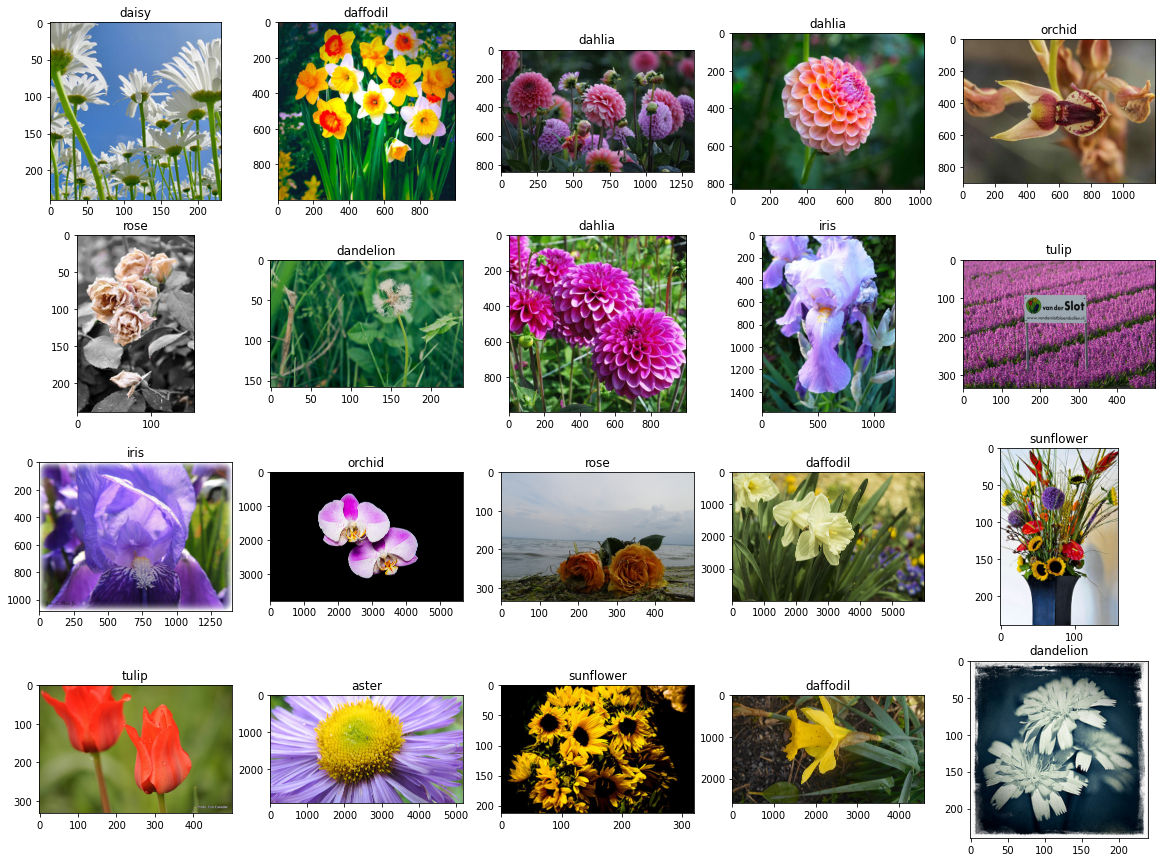

In [4]:
show_random_images(path, flowers)

The images are different sizes, so we will need to resize all of them before feeding them to a neural network. Let's try this first with PIL.

## Image Resizing
Since all images are of different proportions we will need to open the images with PIL and then resize them.

In [5]:
## Compute total number of images
total_images = 0
for flower in flowers:
    total_images += len([name for name in os.listdir(path + flower + '/')])


## Create an array of resized images
images = np.empty((total_images, 75, 75, 3),dtype=np.int32)
labels = np.empty(total_images,dtype=np.int32)
n = 0
for i in range(len(flowers)):
    im_path = path + flowers[i] + '/'
    for name in os.listdir(im_path):
        labels[n] = i
        images[n,:,:,:] = np.array(PIL.Image.open(im_path + name).resize((75,75), PIL.Image.BICUBIC))
        n += 1

The images are now stored in a $(m \times 75 \times 75 \times 3)$ array, where $m$ is the number of training examples. Let's see how the resized images look.

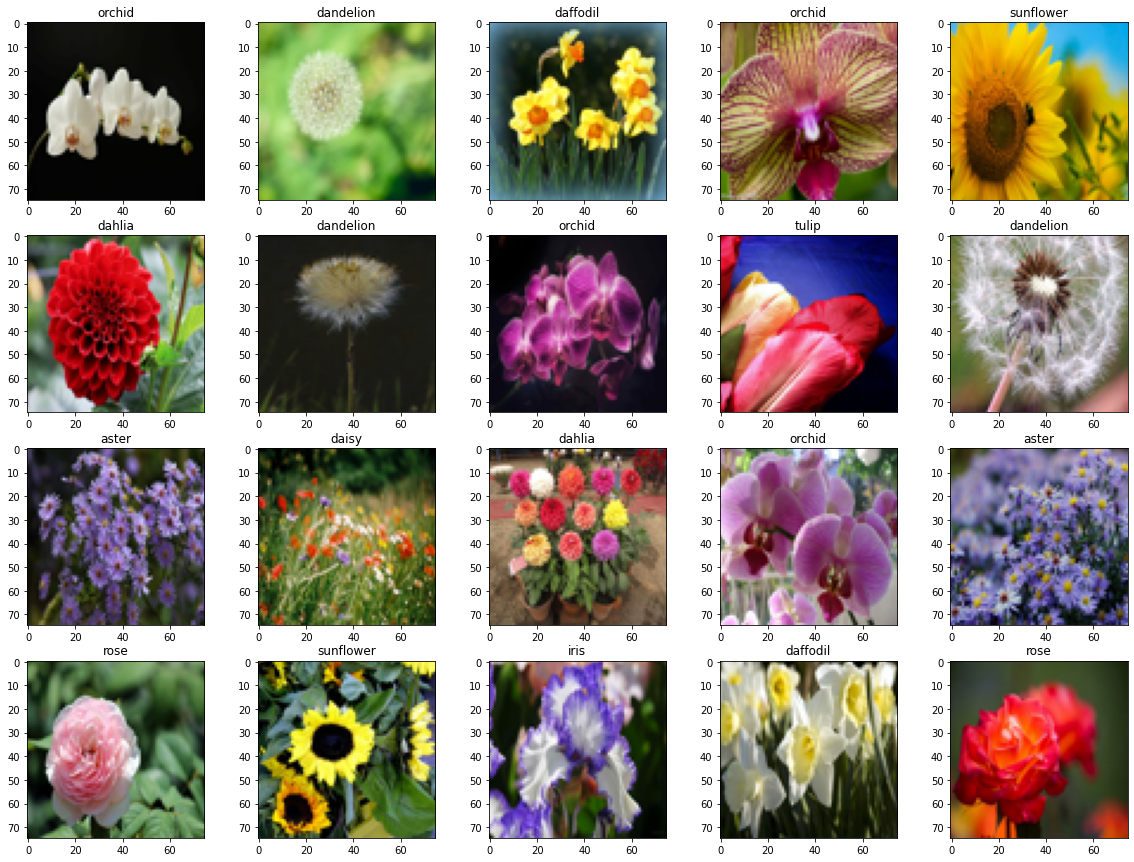

In [6]:
## Plot 20 random images that have been resized in the aprevious step
randomlist = random.sample(range(0, images.shape[0]), 20)
i = 1
for r in randomlist:
    plt.subplot(4,5,i).set_title('{}'.format(flowers[labels[r]]))
    plt.imshow(images[r,:,:,:])
    i += 1

These look pretty decent! It's time to prepare the data by flattening the image arrays and splitting the data into testing and training data.

### Data preparation and Train/Test Split

First thing we will want to do is one-hot encode the target values (i.e., labels).

In [7]:
## Define function that will one-hot encode the target values
def one_hot_encode(target):
    n_values = np.max(target) + 1
    one_hot = np.eye(n_values)[target]
    return(one_hot)

y = one_hot_encode(labels) # one-hot encode target values
X = images

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (8168, 75, 75, 3)
y shape: (8168, 10)


Looks like we have 8,100 images to work with. It is time to perform a train/test split on the data. For now, I will try an 90/10 train/test split.

In [8]:
## Split X and y into training and test features + target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Quick sanity check to make sure we have the desired array shapes
print("X training shape:", X_train.shape)
print("y training shape:", y_train.shape)
print("X testing shape:", X_test.shape)
print("y testing shape:", y_test.shape)

X training shape: (7351, 75, 75, 3)
y training shape: (7351, 10)
X testing shape: (817, 75, 75, 3)
y testing shape: (817, 10)


# Transfer Learning

Let's use the [EfficientNetB7](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB7) model for this approach.
First I will start by defining a function that augments image data which we will call within the model.

In [9]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))    
    return data_augmentation

Let's build the model:

In [10]:
## Define train and test data sets with batch size = 75

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(75)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(75)

2022-02-02 18:58:34.095701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 18:58:34.219056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 18:58:34.219782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 18:58:34.224825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input #preprocess input with pre-trained weights

def transfer_model(image_shape=(75,75), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.EfficientNetB7(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape) 
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)   
    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(len(flowers), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model
    


In [12]:
model = transfer_model()

258088960/258076736 [==============================] - 1s 0us/step


In [13]:
# Define initial epochs and base_learning rate and then compile
initial_epochs = 50
base_lr = 0.001
model.compile(optimizer=tf.optimizers.Adam(learning_rate=base_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 75, 75, 3)         0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 3, 3, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                25610     
Total params: 64,123,297
Trainable params: 25,610
Non-trainable params: 64,097,687
____________________________________________

In [14]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=test_dataset)

Epoch 1/50


2022-02-02 18:59:00.426403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-02 18:59:03.126577: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


99/99 [==============================] - 39s 180ms/step - loss: 1.8160 - accuracy: 0.3579 - val_loss: 1.3935 - val_accuracy: 0.5520
Epoch 2/50
99/99 [==============================] - 13s 131ms/step - loss: 1.4062 - accuracy: 0.5304 - val_loss: 1.1894 - val_accuracy: 0.6291
Epoch 3/50
99/99 [==============================] - 13s 131ms/step - loss: 1.2587 - accuracy: 0.5754 - val_loss: 1.0906 - val_accuracy: 0.6695
Epoch 4/50
99/99 [==============================] - 13s 131ms/step - loss: 1.1635 - accuracy: 0.6194 - val_loss: 1.0197 - val_accuracy: 0.6989
Epoch 5/50
99/99 [==============================] - 13s 133ms/step - loss: 1.1088 - accuracy: 0.6327 - val_loss: 0.9795 - val_accuracy: 0.7026
Epoch 6/50
99/99 [==============================] - 13s 131ms/step - loss: 1.0526 - accuracy: 0.6456 - val_loss: 0.9395 - val_accuracy: 0.7246
Epoch 7/50
99/99 [==============================] - 13s 133ms/step - loss: 1.0185 - accuracy: 0.6658 - val_loss: 0.9175 - val_accuracy: 0.7148
Epoch 8/50

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

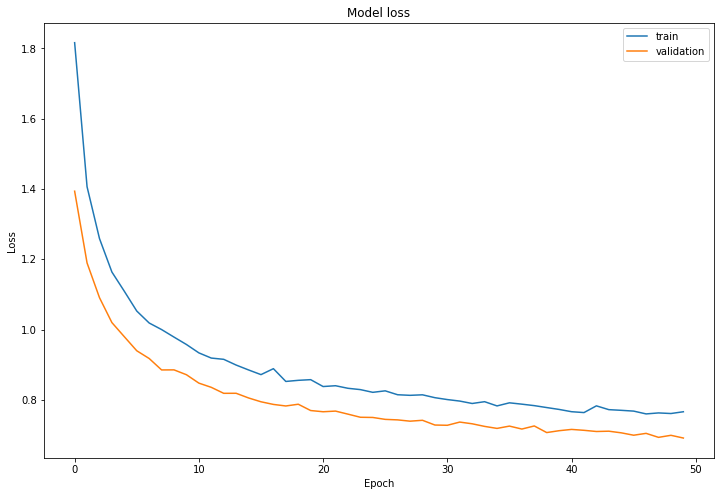

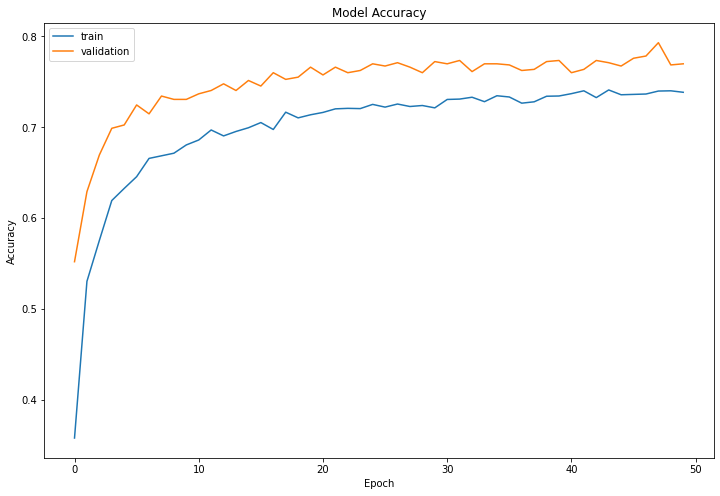

In [15]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

That was an improvement compared to before! Now let's do some fine tuning.

## Fine Tuning

Let's fine tune the model and see if we can improve the score. To do this, I will unfreeze the last few layers of the model and allow training with a smaller learning rate. 

In [16]:
model.layers # See layers, freeze at base model (Functional)

In [17]:
base_model = model.layers[2]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 750 # Start fine tuning at this layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
model.compile(optimizer=tf.optimizers.Adam(learning_rate=base_lr*0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Number of layers in the base model:  813
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 75, 75, 3)         0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 3, 3, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                25610     
Total params: 64,123,297
Trainable params: 23,102,026
Non-trainable params: 41,021,271

In [18]:
fine_tune_epochs = 30 # fine tune for 30 more epochs
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)


Epoch 50/80
99/99 [==============================] - 38s 204ms/step - loss: 0.7730 - accuracy: 0.7370 - val_loss: 0.6431 - val_accuracy: 0.7870
Epoch 51/80
99/99 [==============================] - 16s 158ms/step - loss: 0.6240 - accuracy: 0.7814 - val_loss: 0.5452 - val_accuracy: 0.8250
Epoch 52/80
99/99 [==============================] - 16s 159ms/step - loss: 0.5520 - accuracy: 0.8108 - val_loss: 0.5528 - val_accuracy: 0.8274
Epoch 53/80
99/99 [==============================] - 16s 159ms/step - loss: 0.4916 - accuracy: 0.8316 - val_loss: 0.5201 - val_accuracy: 0.8433
Epoch 54/80
99/99 [==============================] - 16s 159ms/step - loss: 0.4345 - accuracy: 0.8482 - val_loss: 0.5651 - val_accuracy: 0.8372
Epoch 55/80
99/99 [==============================] - 16s 158ms/step - loss: 0.3956 - accuracy: 0.8653 - val_loss: 0.5982 - val_accuracy: 0.8299
Epoch 56/80
99/99 [==============================] - 16s 159ms/step - loss: 0.3627 - accuracy: 0.8712 - val_loss: 0.5672 - val_accuracy:

Not a bad improvement! The test accuracy went from ~77% to ~86%.  To improve this, we could try adding other regularization techniques to the model to reduce overfitting and/or add more training data.

In [19]:
predictions = model.predict(test_dataset)

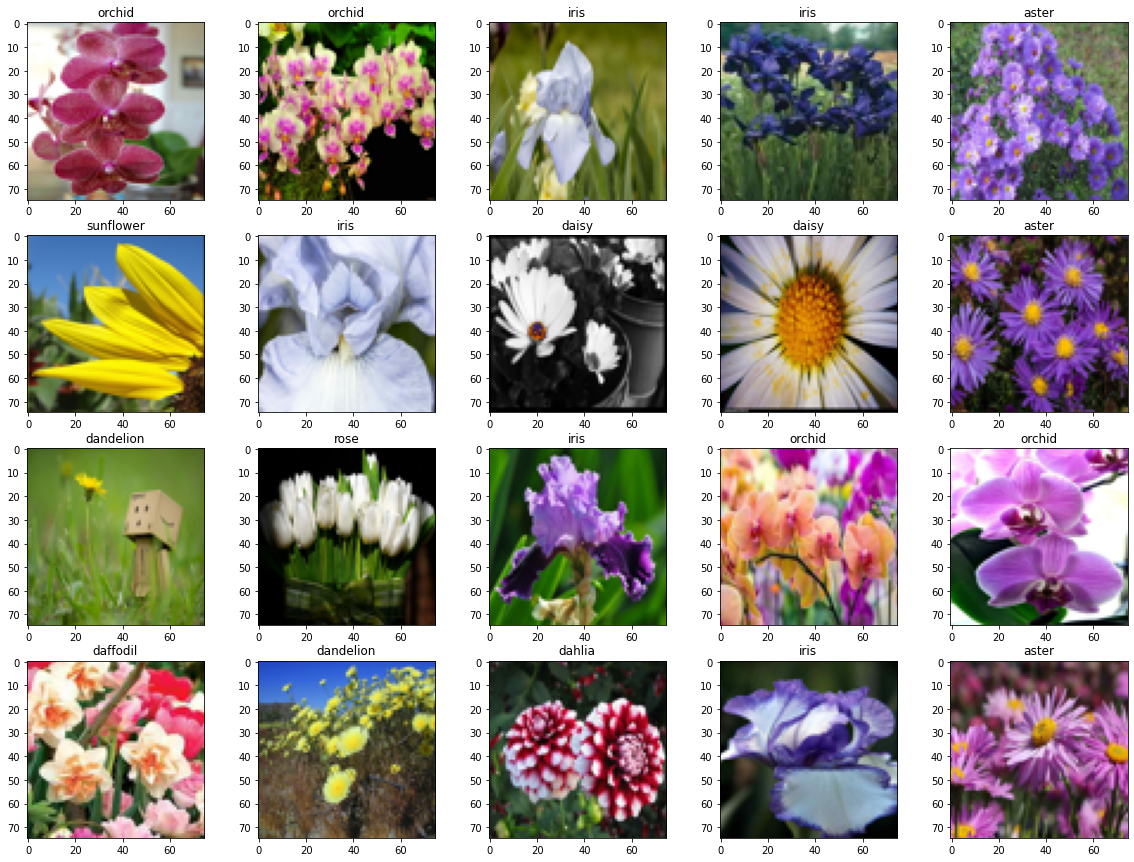

In [20]:
randomlist = random.sample(range(0, predictions.shape[0]), 20)
i = 1
for r in randomlist:
    prediction_idx = np.argmax(predictions[r])
    plt.subplot(4,5,i).set_title('{}'.format(flowers[prediction_idx]))
    plt.imshow(X_test[r,:,:,:])
    i += 1